In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import geopandas as gpd

In [3]:
# importing the county cases mask data
data_mask = pd.read_csv('../clean_data/cases_with_mask_use.csv')

In [4]:
# importing the hospital by county data
data_hosp = pd.read_csv('../clean_data/hospitals_by_county.csv')

In [5]:
data_county_pop = data_mask[['county', 'date' , 'population']]

In [6]:
# merge the hospital county and county population data together.

In [7]:
# lets rename column name for todays_date

data_hosp.rename(columns = {'todays_date':'date'},inplace = True)

In [8]:
# Merge DataFrames
df= pd.merge(data_hosp, data_county_pop , on = [ 'county' , 'date'], how = 'left')


In [163]:
df.county.unique()

array(['Kings', 'Yolo', 'San Diego', 'Modoc', 'Mono', 'Mendocino',
       'Riverside', 'Stanislaus', 'Lassen', 'San Luis Obispo',
       'San Bernardino', 'Merced', 'Shasta', 'San Mateo', 'Marin',
       'Glenn', 'Fresno', 'Napa', 'Los Angeles', 'Trinity', 'San Benito',
       'San Francisco', 'Santa Clara', 'Butte', 'Colusa', 'Monterey',
       'Madera', 'Plumas', 'Tehama', 'Solano', 'Tuolumne', 'Santa Cruz',
       'Contra Costa', 'Del Norte', 'Placer', 'Siskiyou', 'Alameda',
       'Orange', 'San Joaquin', 'Amador', 'Santa Barbara', 'Ventura',
       'Tulare', 'Humboldt', 'Sonoma', 'Calaveras', 'El Dorado', 'Sutter',
       'Sacramento', 'Nevada', 'Inyo', 'Lake', 'Kern', 'Imperial', 'Yuba',
       'Mariposa'], dtype=object)

In [9]:
# check if there are any null columns
df.isna().sum()

county                                   0
date                                     0
hospitalized_covid_confirmed_patients    0
hospitalized_suspected_covid_patients    0
hospitalized_covid_patients              0
all_hospital_beds                        0
icu_covid_confirmed_patients             0
icu_suspected_covid_patients             0
icu_available_beds                       0
population                               6
dtype: int64

In [10]:
# check out which rows have NULL for population
df[df['population'].isna()]

,county,date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds,population
3,Modoc,2020-03-29,0.0,0.0,0.0,11.0,0.0,0.0,0.0,NaN
66,Modoc,2020-03-30,0.0,31.0,31.0,11.0,0.0,0.0,0.0,NaN
89,Lake,2020-03-30,0.0,1.0,1.0,313.0,0.0,1.0,3.0,NaN
111,Modoc,2020-03-31,0.0,19.0,19.0,11.0,0.0,0.0,0.0,NaN
206,Modoc,2020-04-01,0.0,1.0,1.0,11.0,0.0,0.0,0.0,NaN
240,Modoc,2020-04-02,0.0,1.0,1.0,11.0,0.0,0.0,0.0,NaN


In [11]:
# replace nulls with population values for those counties
df.loc[df['county']== 'Modoc','population']= 8841.0
df.loc[df['county']== 'Lake','population']= 64386.0

In [12]:
# create a data frame for the columns we need
df_raw = df[['county','date','hospitalized_covid_patients','population']]

#### Using Geopandas for plotting

In [14]:
df_raw.to_csv('../clean_data/hospitals_by_county_with_pop.csv', index=False)

In [15]:
# set the filepath and load in a shapefile
map_df = gpd.read_file('../data/CA_Counties/CA_Counties_TIGER2016.shp')

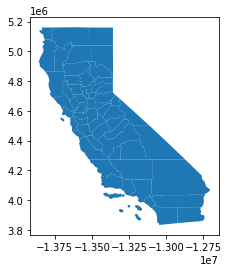

In [16]:
map_df.plot();

In [17]:
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('NAME').join(df_raw.set_index('county'))

In [18]:
merged['percent_covid_pop'] = (merged['hospitalized_covid_patients'] )*100 /  (pd.to_numeric(merged['population'], downcast="float"))

In [19]:
# check if there are any null columns
merged.isna().sum()

STATEFP                            0
COUNTYFP                           0
COUNTYNS                           0
GEOID                              0
NAMELSAD                           0
LSAD                               0
CLASSFP                            0
MTFCC                              0
CSAFP                           6983
CBSAFP                          3200
METDIVFP                       14258
FUNCSTAT                           0
ALAND                              0
AWATER                             0
INTPTLAT                           0
INTPTLON                           0
geometry                           0
date                               2
hospitalized_covid_patients        2
population                         2
percent_covid_pop                  2
dtype: int64

In [20]:
merged["percent_covid_pop"].describe()

count    16293.000000
mean         0.011752
std          0.027148
min          0.000000
25%          0.002074
50%          0.006899
75%          0.013802
max          0.986751
Name: percent_covid_pop, dtype: float64

In [21]:
# Since the range of percent_covid_pop is huge, lets convert it into a log scale

merged['percent_covid_pop_log'] = np.log(merged['percent_covid_pop']) 

/home/jesse/anaconda3/envs/geopandas/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
merged.loc[merged['percent_covid_pop']== 0.0,'percent_covid_pop_log']= 0.0

In [23]:
#merged.drop(merged[merged['percent_covid_pop'] == 0.0].index, inplace = True) 

In [24]:
merged["percent_covid_pop_log"].describe()

count    16293.000000
mean        -3.846514
std          2.052781
min         -7.948424
25%         -5.163687
50%         -4.466804
75%         -3.343647
max          0.000000
Name: percent_covid_pop_log, dtype: float64

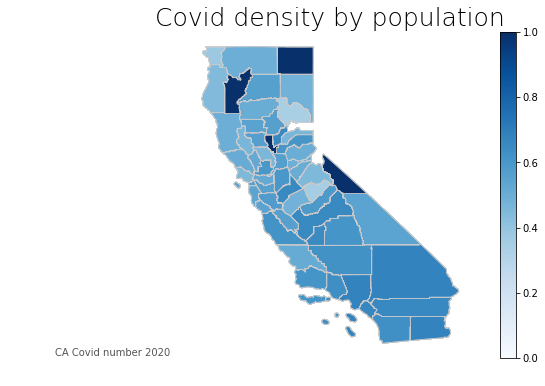

In [25]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percent_covid_pop_log'

# set the range for the choropleth
vmin, vmax = 0 , 1

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))

# create map
merged.plot(column=variable, cmap='brg', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Covid density by population', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('CA Covid number 2020',
           xy=(0.1, 0.1), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='brg', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=500)

In [26]:
merged.groupby(by = 'county').['percent_covid_pop'].max()

SyntaxError: invalid syntax (<ipython-input-26-d7a3ae872aac>, line 1)

In [ ]:
merged.sort_values(by='percent_covid_pop', ascending=False)

In [159]:
merged[merged['NAMELSAD' ] == 'Alpine']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,date,hospitalized_covid_patients,population,percent_covid_pop,percent_covid_pop_log
